In [6]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import resample
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [7]:
def load_mat(matfile):
    m = scipy.io.loadmat(matfile)
    feeg = m['specDat'][0]['fEEG'][0]
    time = feeg[0]      
    eeg  = feeg[1].astype(float)
    sr   = 1.0 / np.diff(time[:2])[0]
    events = m['szEvents']   # [idx, start_s, end_s, dur_s]
    return eeg, sr, events

def to_idx(t, sr):
    return int(round(t * sr))

def sliding_windows(arr, win_len):
    n = len(arr)
    count = n // win_len
    return [arr[i*win_len:(i+1)*win_len] for i in range(count)]

In [15]:
def process_eeg_data(matfile, window_sec=10.0, resample_hz=None, train_ratio=0.8):
    eeg, sr, events = load_mat(matfile)
    
    # optional resampling
    if resample_hz:
        new_len = int(len(eeg) * resample_hz / sr)
        eeg = resample(eeg, new_len)
        sr = resample_hz

    W = int(round(window_sec * sr))

    # build interictal intervals
    seiz = sorted((to_idx(s,sr), to_idx(e,sr)) for _, s,e,_ in events)
    inter = []
    last = 0
    for s,e in seiz:
        if s - last >= W:
            inter.append((last, s))
        last = e
    if len(eeg) - last >= W:
        inter.append((last, len(eeg)))

    # Windows for inter-ictal periods
    inter_wins = []
    for a,b in inter:
        inter_wins += sliding_windows(eeg[a:b], W)
    
    # Windows with seizure events at the END
    seiz_wins = []
    onset_times = []  # Store onset times relative to window start
    
    for s,e in seiz:
        # Check if seizure is long enough to capture a full window
        seizure_duration = e - s
        
        if e >= W:
            # Include window ending at seizure end time (e)
            window_start = e - W
            segment = eeg[window_start:e]
            
            # Calculate onset time relative to window start (in samples)
            if window_start <= s:  # seizure starts within the window
                onset_idx = s - window_start
                onset_time = onset_idx / sr  # convert to seconds
                onset_times.append(onset_time)
            else:  # window starts after seizure onset
                onset_times.append(0)  # seizure starts before window
                
            seiz_wins.append(segment)
    
    # Calculate average onset time within window
    avg_onset_time = np.mean(onset_times) if onset_times else 0
    print(f"Average seizure onset time within window: {avg_onset_time:.2f} seconds")
    
    # balance: down-sample interictal to match seiz count
    N = min(len(inter_wins), len(seiz_wins))
    np.random.shuffle(inter_wins)
    inter_wins = inter_wins[:N]
    seiz_wins = seiz_wins[:N]
    
    # Create labels for each window (0 for inter-ictal, 1 for seizure)
    inter_labels = np.zeros(len(inter_wins))
    seiz_labels = np.ones(len(seiz_wins))
    
    # Combine windows and labels
    all_wins = np.array(inter_wins + seiz_wins)
    all_labels = np.concatenate([inter_labels, seiz_labels])
    
    # Create a single indexed array for shuffling
    indices = np.arange(len(all_wins))
    np.random.shuffle(indices)
    
    # Apply the shuffling
    all_wins = all_wins[indices]
    all_labels = all_labels[indices]
    
    # Split into train and test
    cut = int(train_ratio * len(all_wins))
    train_wins, test_wins = all_wins[:cut], all_wins[cut:]
    train_labels, test_labels = all_labels[:cut], all_labels[cut:]
    
    # Save data
    os.makedirs('data', exist_ok=True)
    pd.DataFrame(train_wins).to_csv('data/train.csv', index=False, header=False)
    pd.DataFrame(test_wins).to_csv('data/test.csv', index=False, header=False)
    
    # Save labels separately
    pd.DataFrame(train_labels).to_csv('data/train_labels.csv', index=False, header=False)
    pd.DataFrame(test_labels).to_csv('data/test_labels.csv', index=False, header=False)
    
    print(f"train: {len(train_wins)} windows, test: {len(test_wins)} windows")
    print(f"Seizure windows: {len(seiz_wins)}, Inter-ictal windows: {len(inter_wins)}")
    
    return {
        'train_wins': train_wins, 
        'test_wins': test_wins,
        'train_labels': train_labels,
        'test_labels': test_labels,
        'sr': sr,
        'window_sec': window_sec,
        'avg_onset_time': avg_onset_time  # Return the average onset time
    }

In [18]:
def visualize_eeg_data(data_dict):
    """
    Create visualizations comparing inter-ictal vs seizure windows
    with clear indication of the average seizure onset time
    """
    train_wins = data_dict['train_wins']
    test_wins = data_dict['test_wins']
    train_labels = data_dict['train_labels']
    test_labels = data_dict['test_labels']
    sr = data_dict['sr']
    window_sec = data_dict['window_sec']
    avg_onset_time = data_dict['avg_onset_time']
    
    # Create time axis for plotting
    time_axis = np.linspace(0, window_sec, train_wins.shape[1])
    
    # Separate windows by type
    train_inter = train_wins[train_labels == 0]
    train_seiz = train_wins[train_labels == 1]
    test_inter = test_wins[test_labels == 0]
    test_seiz = test_wins[test_labels == 1]
    
    # Calculate average signals
    avg_train_inter = np.mean(train_inter, axis=0)
    avg_train_seiz = np.mean(train_seiz, axis=0)
    avg_test_inter = np.mean(test_inter, axis=0)
    avg_test_seiz = np.mean(test_seiz, axis=0)
    
    # Calculate standard deviation for confidence intervals
    std_train_inter = np.std(train_inter, axis=0)
    std_train_seiz = np.std(train_seiz, axis=0)
    std_test_inter = np.std(test_inter, axis=0)
    std_test_seiz = np.std(test_seiz, axis=0)
    
    # Plot Training Data
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.title('Average EEG Signal in Training Set')
    plt.plot(time_axis, avg_train_inter, 'b-', label='Inter-ictal (n={})'.format(len(train_inter)))
    plt.fill_between(time_axis, 
                     avg_train_inter - std_train_inter, 
                     avg_train_inter + std_train_inter, 
                     color='b', alpha=0.2)
    
    plt.plot(time_axis, avg_train_seiz, 'r-', label='Seizure (n={})'.format(len(train_seiz)))
    plt.fill_between(time_axis, 
                     avg_train_seiz - std_train_seiz, 
                     avg_train_seiz + std_train_seiz, 
                     color='r', alpha=0.2)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    # Add annotation for seizure onset and end
    plt.axvline(x=avg_onset_time, color='g', linestyle='--')
    plt.text(avg_onset_time + 0.1, plt.ylim()[1] * 0.9, 'Avg. Seizure Onset: {:.2f}s'.format(avg_onset_time), 
             verticalalignment='top')
    
    plt.axvline(x=window_sec, color='k', linestyle='--')
    plt.text(window_sec - 1.5, plt.ylim()[1] * 0.8, 'Seizure End: {:.2f}s'.format(window_sec), 
             verticalalignment='top')
    
    # Add shaded region from onset to end
    plt.axvspan(avg_onset_time, window_sec, alpha=0.1, color='r', label='Seizure Region')
    
    # Plot Testing Data
    plt.subplot(2, 1, 2)
    plt.title('Average EEG Signal in Testing Set')
    plt.plot(time_axis, avg_test_inter, 'b-', label='Inter-ictal (n={})'.format(len(test_inter)))
    plt.fill_between(time_axis, 
                     avg_test_inter - std_test_inter, 
                     avg_test_inter + std_test_inter, 
                     color='b', alpha=0.2)
    
    plt.plot(time_axis, avg_test_seiz, 'r-', label='Seizure (n={})'.format(len(test_seiz)))
    plt.fill_between(time_axis, 
                     avg_test_seiz - std_test_seiz, 
                     avg_test_seiz + std_test_seiz, 
                     color='r', alpha=0.2)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    # Add annotation for seizure onset and end
    plt.axvline(x=avg_onset_time, color='g', linestyle='--')
    plt.text(avg_onset_time + 0.1, plt.ylim()[1] * 0.9, 'Avg. Seizure Onset: {:.2f}s'.format(avg_onset_time), 
             verticalalignment='top')
    
    plt.axvline(x=window_sec, color='k', linestyle='--')
    plt.text(window_sec - 1.5, plt.ylim()[1] * 0.8, 'Seizure End: {:.2f}s'.format(window_sec), 
             verticalalignment='top')
    
    # Add shaded region from onset to end
    plt.axvspan(avg_onset_time, window_sec, alpha=0.1, color='r', label='Seizure Region')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization showing individual examples
    plt.figure(figsize=(15, 10))
    
    # Plot 10 random examples from each class
    plt.subplot(2, 2, 1)
    plt.title('Sample Inter-ictal Windows (Training)')
    for i in range(min(10, len(train_inter))):
        plt.plot(time_axis, train_inter[i], alpha=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 2, 2)
    plt.title('Sample Seizure Windows (Training)')
    for i in range(min(10, len(train_seiz))):
        plt.plot(time_axis, train_seiz[i], alpha=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    
    # Add annotation for seizure onset and end
    plt.axvline(x=avg_onset_time, color='g', linestyle='--', label='Avg. Seizure Onset')
    plt.axvline(x=window_sec, color='k', linestyle='--', label='Seizure End')
    plt.axvspan(avg_onset_time, window_sec, alpha=0.1, color='r', label='Seizure Region')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.title('Sample Inter-ictal Windows (Testing)')
    for i in range(min(10, len(test_inter))):
        plt.plot(time_axis, test_inter[i], alpha=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 2, 4)
    plt.title('Sample Seizure Windows (Testing)')
    for i in range(min(10, len(test_seiz))):
        plt.plot(time_axis, test_seiz[i], alpha=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    
    # Add annotation for seizure onset and end
    plt.axvline(x=avg_onset_time, color='g', linestyle='--', label='Avg. Seizure Onset')
    plt.axvline(x=window_sec, color='k', linestyle='--', label='Seizure End')
    plt.axvspan(avg_onset_time, window_sec, alpha=0.1, color='r', label='Seizure Region')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # # Plot power spectrum comparison
    # plt.figure(figsize=(15, 10))
    
    # # Calculate power spectrum
    # def power_spectrum(signals):
    #     n_samples = signals.shape[1]
    #     freqs = np.fft.rfftfreq(n_samples, d=1/sr)
    #     spectra = np.abs(np.fft.rfft(signals, axis=1))**2
    #     avg_spectrum = np.mean(spectra, axis=0)
    #     std_spectrum = np.std(spectra, axis=0)
    #     return freqs, avg_spectrum, std_spectrum
    
    # # Training set power spectrum
    # freqs_train_inter, power_train_inter, std_train_inter = power_spectrum(train_inter)
    # freqs_train_seiz, power_train_seiz, std_train_seiz = power_spectrum(train_seiz)
    
    # # Testing set power spectrum
    # freqs_test_inter, power_test_inter, std_test_inter = power_spectrum(test_inter)
    # freqs_test_seiz, power_test_seiz, std_test_seiz = power_spectrum(test_seiz)
    
    # # Plot Training Power Spectrum
    # plt.subplot(2, 1, 1)
    # plt.title('Power Spectrum - Training Set')
    # plt.plot(freqs_train_inter, power_train_inter, 'b-', label='Inter-ictal')
    # plt.fill_between(freqs_train_inter, 
    #                  power_train_inter - std_train_inter, 
    #                  power_train_inter + std_train_inter, 
    #                  color='b', alpha=0.2)
    
    # plt.plot(freqs_train_seiz, power_train_seiz, 'r-', label='Seizure')
    # plt.fill_between(freqs_train_seiz, 
    #                  power_train_seiz - std_train_seiz, 
    #                  power_train_seiz + std_train_seiz, 
    #                  color='r', alpha=0.2)
    
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Power')
    # plt.legend()
    # plt.grid(True)
    # plt.xlim(0, min(50, sr/2))  # Limit to 0-50 Hz or Nyquist frequency
    # plt.yscale('log')
    
    # # Plot Testing Power Spectrum
    # plt.subplot(2, 1, 2)
    # plt.title('Power Spectrum - Testing Set')
    # plt.plot(freqs_test_inter, power_test_inter, 'b-', label='Inter-ictal')
    # plt.fill_between(freqs_test_inter, 
    #                  power_test_inter - std_test_inter, 
    #                  power_test_inter + std_test_inter, 
    #                  color='b', alpha=0.2)
    
    # plt.plot(freqs_test_seiz, power_test_seiz, 'r-', label='Seizure')
    # plt.fill_between(freqs_test_seiz, 
    #                  power_test_seiz - std_test_seiz, 
    #                  power_test_seiz + std_test_seiz, 
    #                  color='r', alpha=0.2)
    
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Power')
    # plt.legend()
    # plt.grid(True)
    # plt.xlim(0, min(50, sr/2))  # Limit to 0-50 Hz or Nyquist frequency
    # plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

Average seizure onset time within window: 3.65 seconds
train: 155 windows, test: 39 windows
Seizure windows: 97, Inter-ictal windows: 97


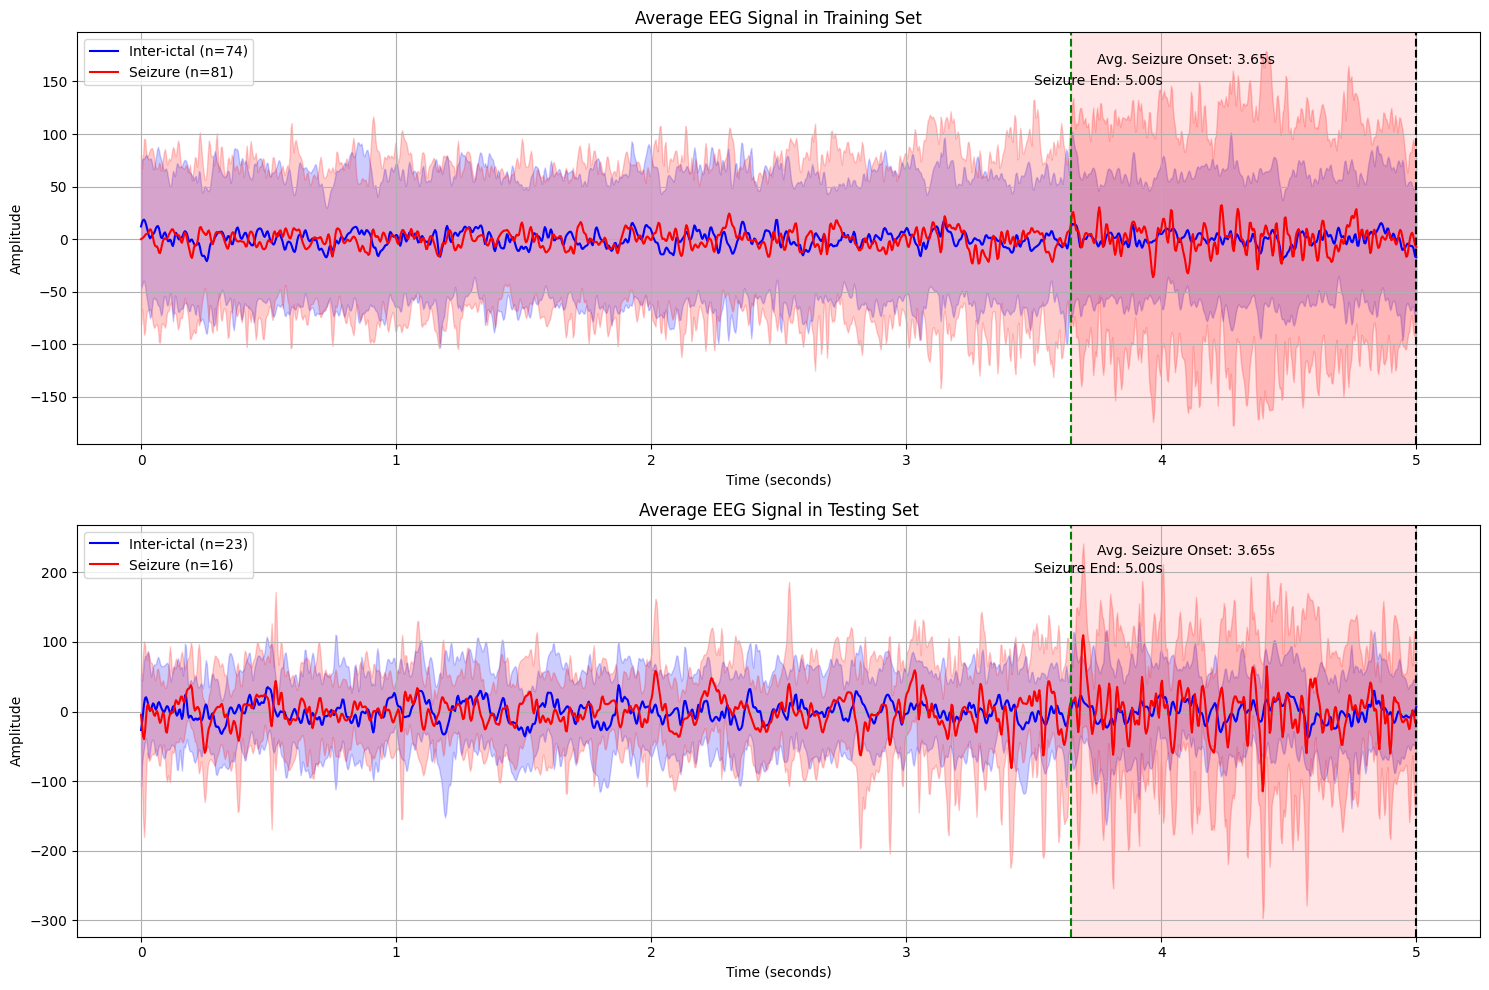

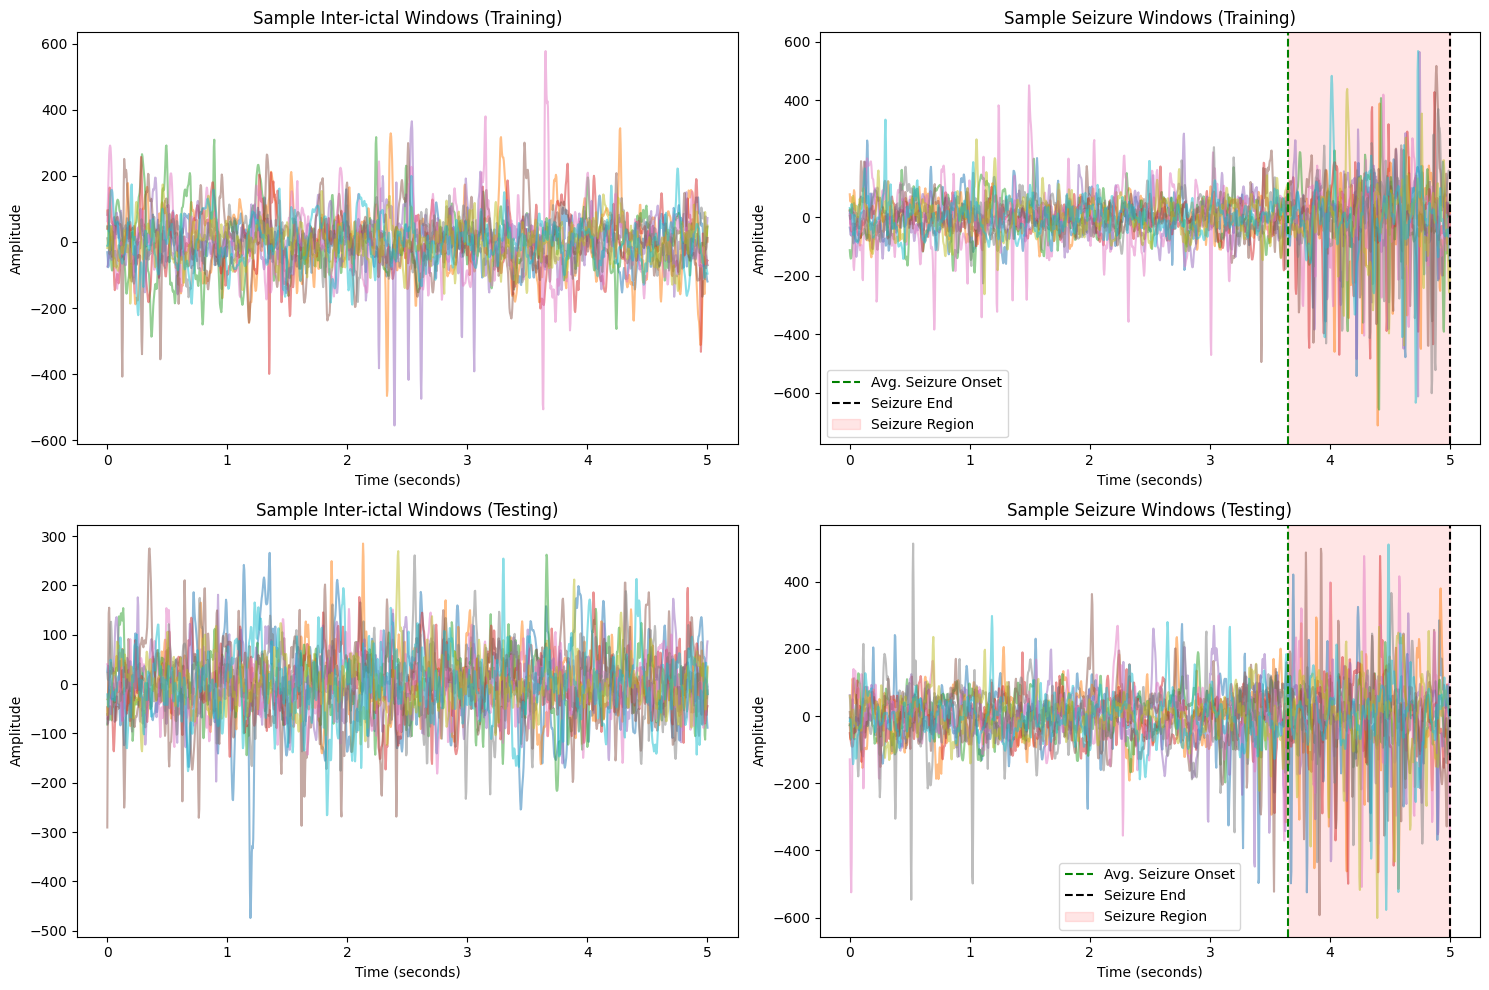

<Figure size 640x480 with 0 Axes>

In [22]:
# Run the entire process
# Replace 'your_matfile.mat' with the actual path to your .mat file
matfile = "D:/EEG/Xiaofu/VPM/M711_het_CaMKII/EEGCamFP20210322-210323-100654/eeg3_m0-60_phot3dots.mat"

# Process the data
data_dict = process_eeg_data(
    matfile=matfile,
    window_sec=5.0,
    resample_hz=256,  # Set to a value if you want to resample
    train_ratio=0.8
)

# Visualize the results
visualize_eeg_data(data_dict)